# Solving Full Cell Simulation Using the Discontinuous Galerkin Method with Interior Penalty
Author: E Leshinka Molel

In this notebook we set to solve the full cell simulation equations for a solid-state battery. The full-cell is simplified to include three domains
- negative electrode
- solid electrolyte (SE) separator
- positive electrode

At the interface between negative electrode and SE, and the interface between SE and positive electrode, we have charge transfer reactions. For simplicity, linear kinetics are assumed.

Phase 1 is the solid active material and phase 2 is the SE.

Current flowing due to charge transfer reaction is given by linear kinetics expression:
$$i = \frac{F i_{o}}{RT}(\phi_1 - \phi_2 - U)$$

The above expression can be written twice, once for -ve electrode and once for +ve electrode.

In our case, for simplicity, infinite kinetics are assumed at the negative electrode and SE separator.

## Setting Up Variational Formulation
$$\nabla \cdot (-\kappa \nabla u) = f$$
$$u(x=0,y) = u_0$$
$$u(x=L_x,y) = u_{L_x}$$
$$-\kappa \nabla u \cdot \hat{n}|_{y=0,y=L_y} = 0$$

The total domain is indicated by $\Omega$ and the external boundary of the domain by $\partial \Omega$.

Because of the internal discontinuity in $u$, we use Discontinuous Lagrange elements. We solve the partial differential equation for each element $K_i$ then sum over all the $N$ elements. This involves multiplying by a test function $v$ and integrating over the element $K_i$.

$$\sum_i^N \int_{K_i} -\nabla \cdot(\kappa u_i) v \mathrm{dx} = \sum_i^N \int_{K_i} f_i v_i \mathrm{dx}$$
Integrating the LHS by parts, we obtain:
$$\sum_i^N \int_{K_i} -\kappa \nabla u_i \cdot \nabla v_i \mathrm{dx} + \sum_i^N \int_{\partial K_i} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = \sum_i^N \int_{K_i} f_i v_i \mathrm{dx}$$

We can split the second term on the LHS to have the parts of the external boundary: $\bigcup \partial \Omega_i = \partial \Omega$ for $i=1,...,N$. Also $\partial \Omega_i \bigcup \partial \hat{K_i} = \partial K_i$.

Therefore, we have:
$$\int_{\Omega} -\kappa \nabla u \cdot \nabla v \mathrm{dx} + \int_{\partial \Omega} \kappa \hat{n} \cdot \nabla u \cdot v \mathrm{ds} + \sum_i^N \int_{\partial \hat{K_i}} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = \int_{\Omega} f v \mathrm{dx}$$

The second term on the LHS can be used to set the Neumann boundary conditions where we have those. Below, we expound further on the third term on the LHS.

We note that for the third term, we have an integral for each side of the integral facet, say between cell $i$ and $j$. We can therefore write this integral as a jump integral (noting that $n_i=-n_j$) over the set of all internal facets $E_j, j=0,\dots,N_{internal}$

\begin{align}
\sum_i^N \int_{\partial \hat{K_i}} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = -\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot [\nabla u_j \cdot v_j] \mathrm{ds}
\end{align}

We can further expand the RHS of above using the relation $[a \cdot b] = \langle a\rangle \cdot [b] + [a] \cdot \langle b \rangle$. Where $\langle \text{value} \rangle$ denotes average of the value across the shared internal boundary. Therefore, we can rewrite our expression above into:

\begin{align}
\sum_i^N \int_{\partial \hat{K_i}} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = -\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot [\nabla u_j] \cdot \langle v_j\rangle \mathrm{ds} -\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot \langle \nabla u_j\rangle \cdot [v_j] \mathrm{ds}
\end{align}

Because we want our solution to be conservative, we enforce that the jump of the gradient in normal direction is zero by removing the term involving $[\nabla u]$ from the RHS of the above expression.

To maintain symmetry when $u$ and $v$ are switched, we add a term $-\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot \langle \nabla v_j\rangle \cdot [u_j] \mathrm{ds}$ to the RHS. We also add another term to the RHS for coercivity: $\int_{E_j}\frac{\gamma}{\langle h \rangle}[u][v]~\mathrm{d}s$ where $h$ is the diameter of the circumscribed circle.

We use Nitsche's method to impose Dirichlet and Neumann boundary conditions on the exterior boundary $\partial \Omega$.

In [1]:
import os

import dolfinx
import gmsh
import matplotlib.pyplot as plt
import meshio
import numpy as np
import ufl
import warnings

from dolfinx import cpp, default_scalar_type, fem, io, mesh, nls, plot
from dolfinx.fem import petsc
from dolfinx.io import VTXWriter
from dolfinx.nls import petsc as petsc_nls
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 dot, div, dx, ds, dS, grad, inner, grad, avg, jump)

import commons, geometry, utils

warnings.simplefilter('ignore')

In [2]:
!rm -r ~/.cache/fenics

In [3]:
encoding = io.XDMFFile.Encoding.HDF5
micron = 1e-6
markers = commons.Markers()
LX = 200 * micron
LY = 250 * micron
points = [
    (0, 0, 0),
    (0.5 * LX, 0, 0),
    (LX, 0, 0),
    (LX, LY, 0),
    (0.5 * LX, LY, 0),
    (0, LY, 0),
]
gpoints = []
lines = []
# workdir = "output/full_cell/165-825-0/1/" 
workdir = "output/subdomains_dg"
utils.make_dir_if_missing(workdir)
output_meshfile = os.path.join(workdir, 'mesh.msh')
tria_meshfile = os.path.join(workdir, "tria.xdmf")
line_meshfile = os.path.join(workdir, "line.xdmf")
potential_resultsfile = os.path.join(workdir, "potential.bp")
potential_dg_resultsfile = os.path.join(workdir, "potential_dg.bp")
concentration_resultsfile = os.path.join(workdir, "concentration.bp")
current_resultsfile = os.path.join(workdir, "current.bp")
current_dg_resultsfile = os.path.join(workdir, "current_dg.bp")

In [4]:
!python3 two_subdomains_2d.py

In [5]:
comm = MPI.COMM_WORLD
with io.XDMFFile(comm, tria_meshfile, "r") as infile3:
    domain = infile3.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
    ct = infile3.read_meshtags(domain, name="Grid")
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, fdim)

ft_imap = domain.topology.index_map(fdim)
num_facets = ft_imap.size_local + ft_imap.num_ghosts
indices = np.arange(0, num_facets)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

with io.XDMFFile(comm, line_meshfile, "r") as infile2:
    ft = infile2.read_meshtags(domain, name="Grid")

values[ft.indices] = ft.values
meshtags = mesh.meshtags(domain, fdim, indices, values)
domaintags = mesh.meshtags(domain, domain.topology.dim, ct.indices, ct.values)

In [6]:
dx = ufl.Measure("dx", domain=domain, subdomain_data=domaintags)
ds = ufl.Measure("ds", domain=domain, subdomain_data=meshtags)
dS = ufl.Measure("dS", domain=domain, subdomain_data=meshtags)

In [7]:
V = fem.FunctionSpace(domain, ("DG", 1))
Q = fem.FunctionSpace(domain, ("DG", 0))
u = fem.Function(V)
v = ufl.TestFunction(V)
n = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)

h = ufl.CellDiameter(domain)
h_avg = avg(h)

In [8]:
f = fem.Constant(domain, PETSc.ScalarType(0))
g = fem.Constant(domain, PETSc.ScalarType(0))
voltage = 1000e-3
u_left = fem.Function(V)
with u_left.vector.localForm() as u0_loc:
    u0_loc.set(0)
u_right = fem.Function(V)
with u_right.vector.localForm() as u1_loc:
    u1_loc.set(voltage)

In [9]:
i0 = fem.Constant(domain, PETSc.ScalarType(1e2))
faraday_const = fem.Constant(domain, PETSc.ScalarType(96485))
R = fem.Constant(domain, PETSc.ScalarType(8.3145))
T = fem.Constant(domain, PETSc.ScalarType(298))

def ocv(sod, L=1, k=2):
    return 2.5 + (1/k) * np.log((L - sod) / sod)

U = ufl.as_vector((ocv(0.975), ocv(0.975), ocv(0.975)))
U = ufl.as_vector((0.15, 0.15, 15))

In [10]:
kappa = fem.Function(Q)
cells_electrolyte = ct.find(markers.electrolyte)
cells_pos_am = ct.find(markers.positive_am)
kappa.x.array[cells_electrolyte] = np.full_like(cells_electrolyte, 0.01, dtype=default_scalar_type)
kappa.x.array[cells_pos_am] = np.full_like(cells_pos_am, 1, dtype=default_scalar_type)

In [11]:
alpha = 10
gamma = 10

F = kappa * inner(grad(u), grad(v)) * dx - f * v * dx - kappa * inner(grad(u), n) * v * ds

# Add DG/IP terms
F += - avg(kappa) * inner(jump(u, n), avg(grad(v))) * dS(0)
F += - inner(jump(kappa * u, n), avg(grad(v))) * dS(0)
F += - inner(avg(kappa * grad(u)), jump(v, n)) * dS(0)
F += + avg(u) * inner(jump(kappa, n), avg(grad(v))) * dS(0)
F += alpha / h_avg * inner(jump(v, n), jump(u, n)) * dS(0)

# Internal boundary
F += - avg(kappa) * dot(avg(grad(v)), (R * T / i0 / faraday_const) * (kappa * grad(u))('+') + U) * dS(markers.electrolyte_v_positive_am)
F += (alpha / h_avg) * avg(kappa) * dot(jump(v, n), (R * T / i0 / faraday_const) * (kappa * grad(u))('+') + U) * dS(markers.electrolyte_v_positive_am)

# # Symmetry
F += - avg(kappa) * inner(jump(u, n), avg(grad(v))) * dS(markers.electrolyte_v_positive_am)

# # Coercivity
F += alpha / h_avg * avg(kappa) * inner(jump(u, n), jump(v, n)) * dS(markers.electrolyte_v_positive_am)

# Nitsche Dirichlet BC terms on left and right boundaries
F += - kappa * (u - u_left) * inner(n, grad(v)) * ds(markers.left)
F += gamma / h * (u - u_left) * v * ds(markers.left)
F += - kappa * (u - u_right) * inner(n, grad(v)) * ds(markers.right) 
F += gamma / h * (u - u_right) * v * ds(markers.right)

# Nitsche Neumann BC terms on insulated boundary
F += -g * v * ds(markers.insulated) + gamma * h * g * inner(grad(v), n) * ds(markers.insulated_electrolyte)
F += - gamma * h * inner(inner(grad(u), n), inner(grad(v), n)) * ds(markers.insulated_electrolyte)
F += -g * v * ds(markers.insulated) + 10 * gamma * h * g * inner(grad(v), n) * ds(markers.insulated_positive_am)
F += - 10 * gamma * h * inner(inner(grad(u), n), inner(grad(v), n)) * ds(markers.insulated_positive_am)

In [12]:
problem = petsc.NonlinearProblem(F, u)
solver = petsc_nls.NewtonSolver(comm, problem)
solver.convergence_criterion = "residual"
solver.maximum_iterations = 5
machine_precision = np.finfo(float).eps
# solver.atol = machine_precision * 1e3
# solver.rtol = machine_precision * 1e2
# solver.atol = 1e-13
# solver.rtol = 1e-11

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "gmres"
opts[f"{option_prefix}pc_type"] = "lu"
ksp.setFromOptions()
n_iters, converged = solver.solve(u)
if not converged:
    print(f"Not converged in {n_iters} iterations")
else:
    print(f"Converged in {n_iters} iterations")
u.name = 'potential'

Converged in 1 iterations


In [13]:
V_CG1 = fem.FunctionSpace(domain, ("CG", 1))

u_cg = fem.Function(V_CG1)
u_cg.name = 'potential'
u_cg.interpolate(u)

with VTXWriter(comm, potential_dg_resultsfile, [u], engine="BP4") as vtx:
    vtx.write(0.0)
with VTXWriter(comm, potential_resultsfile, [u_cg], engine="BP4") as vtx:
    vtx.write(0.0)

In [14]:
W = fem.VectorFunctionSpace(domain, ("DG", 1))
current_expr = fem.Expression(-kappa * grad(u), W.element.interpolation_points())
current_h = fem.Function(W)
current_h.name = 'current_density'
current_h.interpolate(current_expr)

with VTXWriter(comm, current_dg_resultsfile, [current_h], engine="BP4") as vtx:
    vtx.write(0.0)

V_CG0 = fem.VectorFunctionSpace(domain, ("CG", 1))
current_cg = fem.Function(V_CG0)
current_cg.name = 'current_density'
current_cg_expr = fem.Expression(-kappa * grad(u_cg), V_CG0.element.interpolation_points())
current_cg.interpolate(current_cg_expr)

with VTXWriter(comm, current_resultsfile, [current_cg], engine="BP4") as vtx:
    vtx.write(0.0)

I_left = fem.assemble_scalar(fem.form(inner(current_h, n) * ds(markers.left)))
I_right = fem.assemble_scalar(fem.form(inner(current_h, n) * ds(markers.right)))
I_insulated_sse = fem.assemble_scalar(fem.form(np.abs(inner(current_h, n)) * ds(markers.insulated_electrolyte)))
I_insulated_pos_am = fem.assemble_scalar(fem.form(np.abs(inner(current_h, n)) * ds(markers.insulated_positive_am)))
print(f"left: {I_left:.2e} A, right: {abs(I_right):.2e} A")
print(f"insulated electrolyte: {I_insulated_sse:.2e} A, insulated positive am: {I_insulated_pos_am:.2e} A")

left: 2.05e-02 A, right: 2.05e-02 A
insulated electrolyte: 1.45e-08 A, insulated positive am: 1.82e-06 A


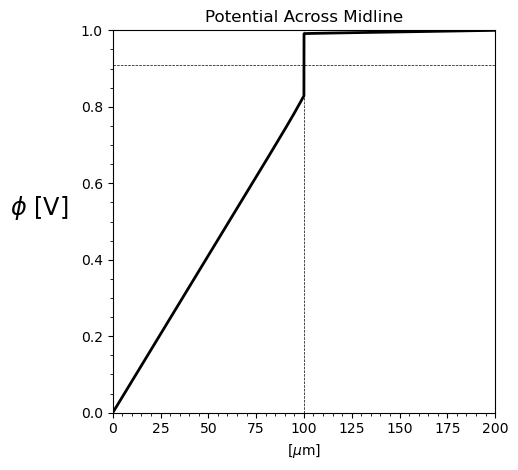

In [15]:
bb_trees = bb_tree(domain, domain.topology.dim)
n_points = 10000
tol = 1e-12  # Avoid hitting the outside of the domain
x = np.linspace(tol, LX - tol, n_points)
y = np.ones(n_points) * 0.5 * LY  # midline
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = compute_collisions_points(bb_trees, points.T)
# Choose one of the cells that contains the point
colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig, ax = plt.subplots()
ax.plot(points_on_proc[:, 0] / micron, u_values, "k", linewidth=2)
ax.axhline(y=10/11, color='k', linestyle='--', linewidth=0.5)
ax.axvline(x=100, color='k', linestyle='--', linewidth=0.5)
# ax.grid(True)
ax.set_xlim([0, LX / micron])
ax.set_ylim([0, voltage])
ax.set_ylabel(r'$\phi$ [V]', rotation=0, labelpad=30, fontsize='xx-large')
ax.set_xlabel(r'[$\mu$m]')
ax.set_title('Potential Across Midline')
ax.set_box_aspect(1)
ax.minorticks_on();
plt.tight_layout()
plt.show()

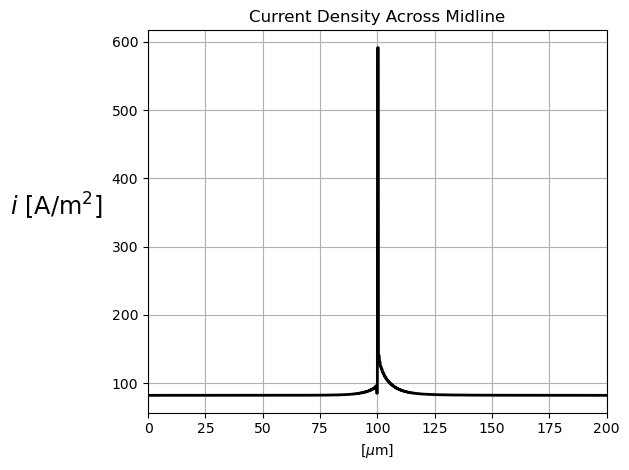

In [16]:
bb_trees = bb_tree(domain, domain.topology.dim)
x = np.linspace(tol, LX - tol, n_points)
y = np.ones(n_points) * 0.5 * LY  # midline
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = compute_collisions_points(bb_trees, points.T)
# Choose one of the cells that contains the point
colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
current_values = current_h.eval(points_on_proc, cells)
fig, ax = plt.subplots()
ax.plot(points_on_proc[:, 0] / micron, np.linalg.norm(current_values, axis=1), "k", linewidth=2)
ax.grid(True)
ax.set_xlim([0, LX / micron])
# ax.set_ylim([0, voltage])
ax.set_ylabel(r'$i$ [A/m$^2$]', rotation=0, labelpad=40, fontsize='xx-large')
ax.set_xlabel(r'[$\mu$m]')
ax.set_title('Current Density Across Midline')
plt.tight_layout()
plt.show()